<a href="https://colab.research.google.com/github/karino2/tegashiki/blob/master/tegashiki_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Tegashiki**

In [19]:
# today tensorflow seems update and batchnormalization name scope is changed. I downgrade for a while
!pip install tensorflow==1.13.1

     |████████████████████████████████| 92.5MB 1.3MB/s 
     |████████████████████████████████| 368kB 34.8MB/s 
     |████████████████████████████████| 3.2MB 35.9MB/s 
  Found existing installation: tensorflow-estimator 1.14.0
    Uninstalling tensorflow-estimator-1.14.0:
      Successfully uninstalled tensorflow-estimator-1.14.0
  Found existing installation: tensorboard 1.14.0
    Uninstalling tensorboard-1.14.0:
      Successfully uninstalled tensorboard-1.14.0
  Found existing installation: tensorflow 1.14.0
    Uninstalling tensorflow-1.14.0:
      Successfully uninstalled tensorflow-1.14.0


In [0]:
import os
import datetime
import pickle
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import preprocessing

In [21]:
tf.VERSION

'1.13.1'

In [22]:
from google.colab import auth
auth.authenticate_user()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [0]:
def get_if_necessary(fname):
  if os.path.exists(fname):
    return
  !gsutil cp gs://karino2-tegashiki/dataset/{fname} {fname}

def get_and_load(fname):
  get_if_necessary(fname)
  with gzip.open(fname,'rb') as f:
    return pickle.load(f)  
  
def send_file(fname):
  !gsutil cp {fname} gs://karino2-tegashiki/dataset/
    
def dump_and_send(obj, fname):
  with gzip.open(fname,'wb') as f:
    pickle.dump(obj, f)
  send_file(fname)


In [0]:
BEGIN_OF_SEQ = 112
END_OF_SEQ=113
PAD_TOKEN=0


# Both train and valid
# MAX_STROKE_NUM=115
MAX_ONE_STROKE_LEN=50
MAX_STROKE_NUM=13

# MAX_TEX_LEN=206+2
# +2 is bos, eos
# +2 is bos, eos
# MAX_TOKEN_LEN=88+2
# MAX_TRAIN_LEN=88+2
MAX_TOKEN_LEN=3+2

VOCAB_SIZE=114


NORMALIZE_MAX=2000

# must match to trained dim
EXTRACTED_FEATURE_DIM=256
FE_DROPOUT_RATE=0.5
FE_L2_REGULARIZATION_RATE=0.1

INPUT_TYPE_POINT=1
INPUT_TYPE_END=0

# (x, y, TYPE)
INPUT_TYPE_DIM=3

### Model

In [0]:
import tensorflow as tf

from tensorflow.keras.layers import Input, GRU, Dense, RepeatVector, Reshape, Concatenate
from tensorflow.keras.layers import TimeDistributed, Flatten, Lambda, Add, Activation, Masking, Embedding
from tensorflow.keras.layers import AveragePooling1D, Conv1D, MaxPooling1D, SpatialDropout1D
from tensorflow.keras.layers import BatchNormalization, Dropout, GlobalMaxPooling1D
from tensorflow.keras import regularizers
import  tensorflow.keras.layers as layers
# from tensorflow.keras.layers.embeddings import Embedding
import tensorflow.keras.backend as K

In [0]:
#DROPOUT_RATE=0.9
DROPOUT_RATE=0.5
L2_REGULARIZATION_RATE=0.1

FEATURE_EXTRACTER_KERNEL_SIZE=7

# FILTER_SIZE=3
# KERNEL_SIZE=8

FILTER_NUM=128
KERNEL_SIZE=5


# large

# EMBEDDING_SIZE=256
# OT_HIDDEN=256
# GRU_HIDDEN=256
# ATTENTION_ENC_HIDDEN=256
# ATTENTION_DEC_HIDDEN=256

# model_small
EMBEDDING_SIZE=32
OT_HIDDEN=128
GRU_HIDDEN=128
ATTENTION_ENC_HIDDEN=64
ATTENTION_DEC_HIDDEN=64

# model_small_embed acc 0.22
# EMBEDDING_SIZE=32

# OT_HIDDEN=256
# GRU_HIDDEN=256
# ATTENTION_ENC_HIDDEN=256
# ATTENTION_DEC_HIDDEN=256



In [0]:
def feature_extractor(input_stroke_t, is_training):
  """input_stroke_t shape (batch, MAX_STROKE_NUM, MAX_ONE_STROKE_LEN, INPUT_TYPE_DIM)
     output: (batch, MAX_STROKE_NUM, EXTRACTED_FEATURE_DIM)"""
  with tf.variable_scope("feature_extractor"):
    inpshape = input_stroke_t.shape
    x = tf.reshape(input_stroke_t, [-1, inpshape[2], inpshape[3]])
    # (batch*MAX_STROKE_NUM, MAX_ONE_STROKE_LEN, INPUT_TYPE_DIM)

    x = Conv1D(32, FEATURE_EXTRACTER_KERNEL_SIZE, kernel_regularizer=regularizers.l2(FE_L2_REGULARIZATION_RATE), bias_regularizer=regularizers.l2(FE_L2_REGULARIZATION_RATE), activity_regularizer=regularizers.l2(FE_L2_REGULARIZATION_RATE))(x)
    x = BatchNormalization()(x, training=is_training)
    x = Activation('relu')(x)
    # (batch*MAX_STROKE_NUM, MAX_ONE_STROKE_LEN, 32)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(FE_DROPOUT_RATE)(x, training=is_training)
    # (batch*MAX_STROKE_NUM, MAX_ONE_STROKE_LEN/2, 32)

    x = Conv1D(64, FEATURE_EXTRACTER_KERNEL_SIZE, kernel_regularizer=regularizers.l2(FE_L2_REGULARIZATION_RATE), bias_regularizer=regularizers.l2(FE_L2_REGULARIZATION_RATE), activity_regularizer=regularizers.l2(FE_L2_REGULARIZATION_RATE))(x)
    x = BatchNormalization()(x, training=is_training)
    x = Activation('relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(FE_DROPOUT_RATE)(x, training=is_training)
    # (batch*MAX_STROKE_NUM, MAX_ONE_STROKE_LEN/4, 64)

    x = Conv1D(EXTRACTED_FEATURE_DIM, 7, kernel_regularizer=regularizers.l2(FE_L2_REGULARIZATION_RATE), bias_regularizer=regularizers.l2(FE_L2_REGULARIZATION_RATE), activity_regularizer=regularizers.l2(FE_L2_REGULARIZATION_RATE))(x)
    x = BatchNormalization()(x, training=is_training)
    x = Activation('relu')(x)
    x = Dropout(FE_DROPOUT_RATE)(x, training=is_training)
    x = GlobalMaxPooling1D()(x)
    x = tf.reshape(x, [-1, inpshape[1], EXTRACTED_FEATURE_DIM])
    return x
  
def attention_context(ht_enc, ht_dec, maxtklen):
  w1 = Dense(ATTENTION_ENC_HIDDEN, kernel_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), bias_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), activity_regularizer=regularizers.l2(L2_REGULARIZATION_RATE))(ht_enc)
  w2 = Dense(ATTENTION_DEC_HIDDEN, kernel_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), bias_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), activity_regularizer=regularizers.l2(L2_REGULARIZATION_RATE))(ht_dec)
  # w1 (sample, 276, 256)
  # w2 (samples, 90, 256)


  w2_widen = tf.expand_dims(w2, axis=1)
  # (sample, 1, 90, 256)

  w1_widen = tf.expand_dims(w1, axis=2)
  # (sample, 276, 1, 256)

  w1_widen_repeat = K.repeat_elements(w1_widen, rep=maxtklen, axis=2)
  # (sample, 276, 90, 256)
  
  score =tf.nn.tanh(w1_widen_repeat+w2_widen)
  prob = Dense(1, activation="softmax", kernel_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), bias_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), activity_regularizer=regularizers.l2(L2_REGULARIZATION_RATE))(score)
  # score: (sample, 276, 90, 256)
  # prob: (sample, 276, 90, 1)

  ht_enc_repeated = K.repeat_elements(tf.expand_dims(ht_enc, axis=2), rep=maxtklen, axis=2)
  # (sample, 276, 90, 256)

  context_vec = tf.reduce_sum(prob*ht_enc_repeated, axis=1)
  # (sample, 90, 256)

  return context_vec  

In [0]:
def encoder_CNN(stroke_enc, is_training, dropout_rate=DROPOUT_RATE):
  x = Conv1D(EXTRACTED_FEATURE_DIM, 13, activation='relu', padding='same', kernel_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), bias_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), activity_regularizer=regularizers.l2(L2_REGULARIZATION_RATE))(stroke_enc)
  x = tf.contrib.layers.layer_norm(x)
  x = SpatialDropout1D(DROPOUT_RATE)(x, training=is_training)
  x = Conv1D(EXTRACTED_FEATURE_DIM, 13, activation='relu', padding='same',kernel_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), bias_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), activity_regularizer=regularizers.l2(L2_REGULARIZATION_RATE))(x)
  x = tf.contrib.layers.layer_norm(x)
  x = SpatialDropout1D(DROPOUT_RATE)(x, training=is_training)
  return x

def encoder_FC(stroke_enc):
  return Dense(EXTRACTED_FEATURE_DIM, kernel_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), bias_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), activity_regularizer=regularizers.l2(L2_REGULARIZATION_RATE))(stroke_enc)
  

In [0]:
"""
def myembedding(input, num_classes, embedding_size, name):
  randinitializer = lambda: tf.random_uniform([num_classes, embedding_size], -1.0, 1.0)
  embedmat = tf.get_variable(name, initializer = randinitializer)
  return tf.nn.embedding_lookup(embedmat, input)  
"""

# dynamic shape cause TPUEstimator export to fail...
def myembedding(input, num_classes, embedding_size, seq_num, name):
  with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
    randinitializer = lambda: tf.random_uniform([num_classes, embedding_size], -0.05, 0.05)

    embedmat = tf.get_variable(name, initializer = randinitializer)
    # embedding_lookup with generated tensor (eg. tf.range) cause TFLite convert fail.
    # return tf.nn.embedding_lookup(embedmat, input)
    onehot = tf.one_hot(input, num_classes)
    # batch_num, seqnum = onehot.shape[0], onehot.shape[1]    
    # flatten_onehot = tf.reshape(onehot, [batch_num*seq_num, num_classes])
    flatten_onehot = tf.reshape(onehot, [-1, num_classes])
    return tf.reshape(tf.matmul(flatten_onehot, embedmat), [-1, seq_num, embedding_size])


In [0]:
def decoder_CNN(decoder_input_t, is_training):
  # dec_input_embedded = Embedding(VOCAB_SIZE, EMBEDDING_SIZE, input_length=decoder_input_t.shape[1])(decoder_input_t)
  dec_input_embedded = myembedding(decoder_input_t, VOCAB_SIZE, EMBEDDING_SIZE, MAX_TOKEN_LEN, "dec_embed")
  # (batch, 98, 256)
  
  dec_pos_input = tf.range(
            0,
            tf.shape(decoder_input_t)[1],
            delta=1,
            dtype=tf.int32,
            name='range')
  
  # [5] -> [1, 5, 1]
  # dec_pos_input = tf.expand_dims(tf.expand_dims(dec_pos_input, axis=1), axis=0)
  # [5] -> [1, 5]
  dec_pos_input = tf.expand_dims(dec_pos_input, axis=0)
  # dec_pos_embed = Embedding(MAX_TOKEN_LEN, EMBEDDING_SIZE, input_length=MAX_TOKEN_LEN)(dec_pos_input)
  dec_pos_embed = myembedding(dec_pos_input, MAX_TOKEN_LEN, EMBEDDING_SIZE, MAX_TOKEN_LEN, "dec_pos_embed")
  
  
  dec_embedded = dec_input_embedded + tf.cast(x=dec_pos_embed, dtype=dec_input_embedded.dtype)
  # Dimensions must be equal, but are 32 and 5 for 'add_2' (op: 'Add') with input shapes:
  # [32,5,32], [1,5,1,32].
  
  x = Conv1D(FILTER_NUM, KERNEL_SIZE, activation='relu', padding='causal', kernel_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), bias_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), activity_regularizer=regularizers.l2(L2_REGULARIZATION_RATE))(dec_embedded)
  # This will cause future information leak!
  # x = tf.contrib.layers.layer_norm(x)
  return SpatialDropout1D(DROPOUT_RATE)(x, training=is_training)


In [0]:


#input_from_encoder_t (8190, 2773, 3)
#decoder_input_t (batch, tklen, 3)

def create_model(input_stroke_t, decoder_input_t, is_training):
  stroke_features = feature_extractor(input_stroke_t, is_training)
  # (batch, MAX_STROKE_NUM, EXTRACTED_FEATURE_DIM)
  
  # ht_enc, state_enc = encoder_TCN(input_from_encoder_t)
  # ht_enc, state_enc = encoder_CNNRNN(input_from_encoder_t)
  # ht_enc, state_enc = GRU(GRU_HIDDEN, return_sequences=True,return_state=True, dropout=DROPOUT_RATE, recurrent_dropout=DROPOUT_RATE, kernel_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), bias_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), activity_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), recurrent_regularizer=regularizers.l2(L2_REGULARIZATION_RATE))(stroke_features)

  pos_stroke = tf.range(
            0,
            tf.shape(stroke_features)[1],
            delta=1,
            dtype=tf.int32,
            name='range')
  # pos_stroke = tf.expand_dims(tf.expand_dims(pos_stroke, axis=1), axis=0)
  pos_stroke = tf.expand_dims(pos_stroke, axis=0)
  pos_stroke_embed = myembedding(pos_stroke, MAX_STROKE_NUM, EXTRACTED_FEATURE_DIM, MAX_STROKE_NUM, "stroke_pos_embed")
  # pos_stroke_embed = Embedding(MAX_STROKE_NUM, EXTRACTED_FEATURE_DIM, input_length=MAX_STROKE_NUM)(pos_stroke)
  
  stroke_pos_embedded = stroke_features + tf.cast(x=pos_stroke_embed, dtype=stroke_features.dtype)
  
  # InvalidArgumentError: Dimensions must be equal, but are 32 and 13 for 'add_1' (op: 'Add')
  #   with input shapes: [32,13,256], [1,13,1,256].


  # ht_enc = stroke_pos_embedded
  ht_enc = encoder_CNN(stroke_pos_embedded, is_training)
  # ht_enc = encoder_FC(stroke_pos_embedded)
 
  ht_dec = decoder_CNN(decoder_input_t, is_training)

  context_vec = attention_context(ht_enc, ht_dec, decoder_input_t.shape[1])
  # context_vec = attention_context(conved, ht_dec, maxtklen)
  # (sample, 90, 256)

  # ht: (sample, 98, 256)
  # ot_input: (sample, 98, 1536) 

  ot_input = Concatenate()([ht_dec, context_vec])

  # (Sample, 98, 256)
  ot = Dense(OT_HIDDEN, activation="tanh", kernel_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), bias_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), activity_regularizer=regularizers.l2(L2_REGULARIZATION_RATE))(ot_input)

  # (Sample, 98, 112)
  logit = TimeDistributed(Dense(VOCAB_SIZE, kernel_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), bias_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), activity_regularizer=regularizers.l2(L2_REGULARIZATION_RATE)))(ot)

  return logit


In [0]:
def create_rnn_model(input_stroke_t, decoder_input_t, is_training):
  stroke_features = feature_extractor(input_stroke_t, is_training)
  
  ht_enc, state_enc = GRU(GRU_HIDDEN, return_sequences=True,return_state=True, dropout=DROPOUT_RATE, recurrent_dropout=DROPOUT_RATE, kernel_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), bias_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), activity_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), recurrent_regularizer=regularizers.l2(L2_REGULARIZATION_RATE))(stroke_features, training=is_training)

 
  dec_input_embedded = Embedding(VOCAB_SIZE, EMBEDDING_SIZE, input_length=decoder_input_t.shape[1])(decoder_input_t)
  # (batch, 98, 256)


  # (sample, timestamps, htdim)
  ht_dec = GRU(GRU_HIDDEN, return_sequences=True, dropout=DROPOUT_RATE, recurrent_dropout=DROPOUT_RATE, kernel_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), bias_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), activity_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), recurrent_regularizer=regularizers.l2(L2_REGULARIZATION_RATE))(dec_input_embedded, initial_state=state_enc, training=is_training)

  context_vec = attention_context(ht_enc, ht_dec, decoder_input_t.shape[1])
  # context_vec = attention_context(conved, ht_dec, maxtklen)
  # (sample, 90, 256)

  # ht: (sample, 98, 256)
  # ot_input: (sample, 98, 1536) 

  ot_input = Concatenate()([ht_dec, context_vec])

  # (Sample, 98, 256)
  ot = Dense(OT_HIDDEN, activation="tanh", kernel_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), bias_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), activity_regularizer=regularizers.l2(L2_REGULARIZATION_RATE))(ot_input)

  # (Sample, 98, 112)
  logit = TimeDistributed(Dense(VOCAB_SIZE, kernel_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), bias_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), activity_regularizer=regularizers.l2(L2_REGULARIZATION_RATE)))(ot)

  return logit


In [0]:
def sparse_softmax_cross_entropy_with_mask(sparse_labels, logit, mask):
  mask = tf.cast(mask, tf.float32)
  mask_expands = tf.expand_dims(mask, axis=2)
  return tf.losses.sparse_softmax_cross_entropy(sparse_labels, logit, mask_expands)

In [33]:
from tqdm.autonotebook import tqdm as tqdmn

/usr/local/lib/python3.6/dist-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


## TPUEstimator

In [0]:
DATA_DIR="gs://karino2-tegashiki/dataset"
TF_RECORD_FILE="{}/crohme2019_onesupsubtwo_train.tfrecord.gz".format(DATA_DIR)
TF_VALID_RECORD_FILE="{}/crohme2019_onesupsubtwo_valid.tfrecord.gz".format(DATA_DIR)
FEATURE_EXTRACTOR_DIR="gs://karino2-tegashiki/sym_models/rnn_fdim256"

In [0]:
# !gsutil ls gs://karino2-tegashiki/models/

In [0]:
# MODEL_DIR="gs://karino2-tegashiki/models/convencdec_myembed_smallinit"
# MODEL_DIR="gs://karino2-tegashiki/models/convencdec_enc256x13dec128x5"
MODEL_DIR="gs://karino2-tegashiki/models/expgen_rnn_small_dropout05"


In [36]:
import datetime
import json
import os
import pprint
import random
import string
import sys
import tensorflow as tf

assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
print('TPU address is', TPU_ADDRESS)

with tf.Session(TPU_ADDRESS) as session:
  print('TPU devices:')
  pprint.pprint(session.list_devices())

  # Upload credentials to TPU.
  with open('/content/adc.json', 'r') as f:
    auth_info = json.load(f)
  tf.contrib.cloud.configure_gcs(session, credentials=auth_info)
  # Now credentials are set for all future sessions on this TPU.

TPU address is grpc://10.100.94.18:8470
TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 13198592094285856933),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 9072493238014390841),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 10926555743782264542),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 12765751983840090693),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 11648729370430573148),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 16719587456067905581),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 9699973122333253225),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 4844053032161907828),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 82297311502

In [0]:
VALID_SAMPLE_NUM=23884

In [0]:
TRAIN_STEP_PER_ONCE=1000
EVAL_BATCH_SIZE=8

In [0]:
def parser(serialized_example):
  featurelen = MAX_STROKE_NUM*MAX_ONE_STROKE_LEN
  
  features = tf.parse_single_example(
      serialized_example,
      features={
      'input_x': tf.FixedLenFeature([featurelen], tf.int64),
      'input_y': tf.FixedLenFeature([featurelen], tf.int64),
      'input_type': tf.FixedLenFeature([featurelen], tf.int64),
      'decoder_input':tf.FixedLenFeature([MAX_TOKEN_LEN], tf.int64),
      'decoder_labels':tf.FixedLenFeature([MAX_TOKEN_LEN], tf.int64)}          
  )
  
  input_x, input_y, input_type = [tf.reshape(tf.cast(features[fname], tf.int32), [MAX_STROKE_NUM, MAX_ONE_STROKE_LEN]) for fname in ['input_x', 'input_y', 'input_type']]
  one_sample_stroke = tf.stack([input_x, input_y, input_type], 2)
  decoder_input = tf.cast(features["decoder_input"], tf.int32)
  decoder_labels = tf.cast(features["decoder_labels"], tf.int32)
  
  return {"input_stroke": one_sample_stroke, "input_decoder": decoder_input} , decoder_labels

In [0]:
def tpu_input_fn(params):
  dataset = tf.data.TFRecordDataset(TF_RECORD_FILE, "GZIP")
  dataset = dataset.map(parser)
  dataset = dataset.shuffle(1000).repeat()
  dataset = dataset.batch(params['batch_size'], drop_remainder=True)
  return dataset

def tpu_input_fn_valid(params):
  dataset = tf.data.TFRecordDataset(TF_VALID_RECORD_FILE, "GZIP")
  dataset = dataset.map(parser)
  dataset = dataset.batch(params['batch_size'], drop_remainder=True)
  return dataset

In [0]:
def metric_fn(labels, logits, predicted_classes, mask_weights):
    """Function to return metrics for evaluation."""

      
    accuracy = tf.metrics.accuracy(labels=labels,
                                   predictions=predicted_classes,
                                   weights=mask_weights,
                                   name="acc_op")
    return {"accuracy": accuracy}

def extract_params(features, mode, params): 
  input_stroke = tf.feature_column.input_layer(features, params['input_stroke'])

  #[MAX_STROKE_NUM, MAX_ONE_STROKE_LEN]
  input_stroke = tf.reshape(input_stroke, shape=(-1,MAX_STROKE_NUM, MAX_ONE_STROKE_LEN, INPUT_TYPE_DIM))
  input_for_dec= tf.feature_column.input_layer(features, params['input_for_dec'])
  # Why I have to?
  input_for_dec = tf.cast(input_for_dec,tf.int32)
  
  return (input_stroke, input_for_dec)
  
def tpu_model_fn(features, labels, mode, params):
  input_stroke, input_for_dec = extract_params(features, mode, params)
  # input_stroke, input_for_dec, maxtklen = extract_params_always_train(features, mode, params)
  
  # logit = create_model(input_stroke, input_for_dec, mode==tf.estimator.ModeKeys.TRAIN)
  logit = create_rnn_model(input_stroke, input_for_dec, mode==tf.estimator.ModeKeys.TRAIN)
  # maxtklen = MAX_TOKEN_LEN
  # logit = create_model_nostroke(input_stroke, input_for_dec, maxtklen)
  
  
  mask = tf.not_equal(input_for_dec, 0)
  mask_int = tf.cast(mask, tf.int64)
  
  predicted_classes = tf.math.argmax(logit,axis=2)*mask_int
  
  if mode == tf.estimator.ModeKeys.PREDICT:
    predictions = {
        # In TFLite Intepreter, this output fail for allocate tensor.
        # "class_ids": predicted_classes[:, tf.newaxis],
        "logits": logit,
    }
    return tf.contrib.tpu.TPUEstimatorSpec(mode, predictions=predictions)  
  
  loss = sparse_softmax_cross_entropy_with_mask(labels, logit, mask)

  if mode == tf.estimator.ModeKeys.EVAL:
    return tf.contrib.tpu.TPUEstimatorSpec(
        mode=mode, loss=loss, eval_metrics=(metric_fn, [labels, logit, predicted_classes, tf.cast(mask, tf.float32)]))
  
  optimizer = tf.train.AdamOptimizer(params['learning_rate'])  
  optimizer = tf.contrib.tpu.CrossShardOptimizer(optimizer)  
  
  train_op = optimizer.minimize(loss, global_step=tf.train.get_global_step())
  return tf.contrib.tpu.TPUEstimatorSpec(mode, loss=loss, train_op=train_op)


In [0]:
wss = tf.estimator.WarmStartSettings(ckpt_to_initialize_from=FEATURE_EXTRACTOR_DIR, vars_to_warm_start=".*feature_extractor.*")
# wss = None

In [0]:
cluster_resolver = tf.contrib.cluster_resolver.TPUClusterResolver(tpu=TPU_ADDRESS)
is_per_host = tf.contrib.tpu.InputPipelineConfig.PER_HOST_V2


In [0]:
run_config = tf.contrib.tpu.RunConfig(
    cluster=cluster_resolver,
    master=None,
    model_dir=MODEL_DIR,
    save_checkpoints_steps=100,
    tpu_config=tf.contrib.tpu.TPUConfig(
        iterations_per_loop=1000,
        num_shards=8,
        per_host_input_for_training=is_per_host
        # per_host_input_for_training=False
    ))

tpu_estimator = tf.contrib.tpu.TPUEstimator(
    use_tpu=False,
    model_fn=tpu_model_fn,
    config=run_config,
    export_to_tpu=False, # Conv1D cause error for TPU graph with ReadVariableOp. why?
    params={
        'input_stroke':tf.feature_column.numeric_column(key="input_stroke", shape=(MAX_STROKE_NUM, MAX_ONE_STROKE_LEN, INPUT_TYPE_DIM)),
        'input_for_dec': tf.feature_column.numeric_column(key="input_decoder", shape=(MAX_TOKEN_LEN,), dtype=tf.int32),
    },
    warm_start_from=wss,
    train_batch_size=8*32,
    eval_batch_size=EVAL_BATCH_SIZE,
    predict_batch_size=1)

### Validation dataset extract

In [0]:
dataset = tf.data.TFRecordDataset(TF_VALID_RECORD_FILE, "GZIP")
dataset = dataset.map(parser)

In [0]:
res = []

with tf.Session() as sess:
  iterator = dataset.make_one_shot_iterator()
  next_element = iterator.get_next()

  for i in range(1000):
    res.append(sess.run(next_element))

In [0]:
validation_data = res

In [0]:
res[0][0]['input_stroke'].shape

(13, 50, 3)

In [0]:
len(res[0])

2

In [0]:
res[0][1]

array([ 77,  75,  90, 113,   0], dtype=int32)

In [0]:
res[0][0]['input_decoder'].shape

(5,)

### Predict

In [0]:
tf.logging.set_verbosity(tf.logging.ERROR)

In [0]:
def create_input_fn(stroke_input_arr, decoder_input_arr):
  def predict_input(params):
      stroke_input = tf.expand_dims(tf.constant(stroke_input_arr, dtype=tf.int32), axis=0) 
      decoder_input = tf.expand_dims(tf.constant(decoder_input_arr, dtype=tf.int32), axis=0)

      return tf.data.Dataset.from_tensors({"input_stroke": stroke_input, "input_decoder": decoder_input})
  return predict_input

In [0]:
def predict_raw(stroke, decoder_input):
  return next(tpu_estimator.predict(input_fn=create_input_fn(stroke, decoder_input)))['logits']

def predict(stroke, decoder_input):
  logits = predict_raw(stroke, decoder_input)
  return [logits[i, :].argmax() for i in range(5)]

In [0]:
res[4][0]['input_stroke'].tolist()

In [0]:
predict(res[4][0]['input_stroke'],  np.array([112, 0, 0, 0, 0]))

[109, 79, 113, 113, 0]

In [0]:
predict(res[4][0]['input_stroke'],  np.array([112, 109, 0, 0, 0]))

[109, 75, 113, 113, 0]

In [0]:
predict(res[4][0]['input_stroke'],  np.array([112, 109, 75, 0, 0]))

[109, 75, 79, 113, 0]

In [0]:
predict(res[4][0]['input_stroke'],  np.array([112, 109, 75, 79, 0]))

[109, 75, 79, 113, 0]

In [0]:
res[4][0]['input_decoder']

array([112, 109,  75,  79, 113], dtype=int32)

In [0]:
predict(res[0][0]['input_stroke'],  np.array([112, 77, 75, 90, 113]))

[76, 75, 76, 113, 0]

### Plot data

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
def plot_stroke(stroke):
  for i in range(len(stroke)):
    if stroke[i][0, 2] == 1:
      poslis = stroke[i][stroke[i][:, 2]==1]
      plt.plot(poslis[:, 0],-poslis[:, 1])

In [0]:
stroke = res[0][0]['input_stroke']

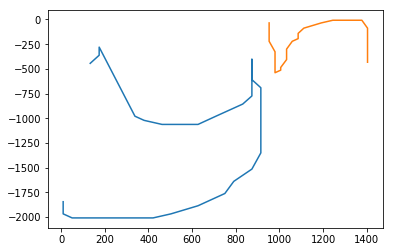

In [0]:
plot_stroke(res[4][0]['input_stroke'])

In [0]:
res[4][1]

array([109,  75,  79, 113,   0], dtype=int32)

### dumped data check

In [0]:
def listi(lis, pos):
  return np.array([tup[pos] for tup in lis])

def plot_list(lis):
    plt.plot(listi(lis, 0),-listi(lis, 1))
    
def plot_lis2(lislis):
  for i in range(len(lislis)):
    plot_list(lislis[i])

In [0]:
import json

In [0]:
with open("20190627_20335244.json") as f:
  data = json.load(f)

In [0]:
import numpy as np

In [0]:
rawdata = data[0]

In [0]:
normalized = np.array(data[1]).reshape(13, 50, 3)

In [17]:
normalized.shape

(13, 50, 3)

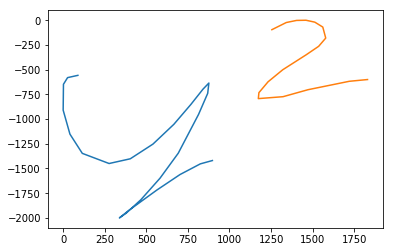

In [18]:
plot_stroke(normalized)

In [48]:
predict(normalized,  np.array([112, 0, 0, 0, 0]))

[22, 49, 113, 113, 0]

In [49]:
predict(normalized,  np.array([112, 22, 0, 0, 0]))

[22, 47, 113, 113, 0]

In [50]:
predict(normalized,  np.array([112, 22, 47, 0, 0]))

[22, 47, 65, 113, 0]

In [51]:
predict(normalized,  np.array([112, 22, 47, 65, 0]))

[22, 47, 65, 113, 0]

rnn

In [60]:
predict(normalized,  np.array([112, 0, 0, 0, 0]))

[109, 75, 113, 0, 0]

In [61]:
predict(normalized,  np.array([112, 109, 0, 0, 0]))

[109, 75, 113, 0, 0]

In [62]:
predict(normalized,  np.array([112, 109, 75, 0, 0]))

[109, 75, 65, 113, 0]

In [63]:
predict(normalized,  np.array([112, 109, 75, 65, 0]))

[109, 75, 65, 113, 0]

### Normalize check (to compare to kotlin side)

In [0]:
stroke_input = np.array([[[94, 1155, 1], [147, 1145, 1], [207, 1151, 1], [273, 1179, 1], [340, 1218, 1], [407, 1275, 1], [467, 1349, 1], [510, 1425, 1], [543, 1508, 1], [564, 1588, 1], [573, 1667, 1], [567, 1738, 1], [550, 1798, 1], [530, 1848, 1], [501, 1895, 1], [467, 1928, 1], [427, 1961, 1], [384, 1981, 1], [340, 1998, 1], [297, 2004, 1], [257, 2008, 1], [221, 2008, 1], [188, 2004, 1], [157, 2000, 1], [134, 1991, 1], [114, 1987, 1], [101, 1974, 1], [94, 1967, 1], [88, 1951, 1], [84, 1941, 1], [88, 1928, 1], [84, 1908, 1], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]], [[7, 263, 1], [11, 276, 1], [14, 319, 1], [18, 382, 1], [21, 472, 1], [24, 579, 1], [24, 709, 1], [27, 842, 1], [27, 981, 1], [24, 1114, 1], [21, 1238, 1], [21, 1349, 1], [18, 1451, 1], [14, 1534, 1], [11, 1608, 1], [7, 1667, 1], [7, 1715, 1], [11, 1754, 1], [14, 1782, 1], [21, 1788, 1], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]], [[681, 8, 1], [667, 26, 1], [615, 520, 1], [615, 516, 1], [615, 511, 1], [615, 492, 1], [615, 483, 1], [620, 446, 1], [629, 427, 1], [653, 395, 1], [662, 381, 1], [699, 353, 1], [709, 348, 1], [755, 348, 1], [765, 348, 1], [806, 353, 1], [816, 357, 1], [839, 390, 1], [839, 404, 1], [839, 436, 1], [834, 450, 1], [802, 483, 1], [788, 492, 1], [741, 516, 1], [727, 520, 1], [681, 530, 1], [667, 530, 1], [643, 525, 1], [639, 520, 1], [629, 506, 1], [629, 502, 1], [629, 497, 1], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]], [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]], [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]], [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]], [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]], [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]], [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]], [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]], [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]], [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]], [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]]],
                       dtype=np.float32)

In [0]:
out_tensor = np.zeros_like(stroke_input)

In [0]:
xmax = stroke_input[stroke_input[:, :, 2] == 1][:, 0].max()
ymax = stroke_input[stroke_input[:, :, 2] == 1][:, 1].max()
xmin = stroke_input[stroke_input[:, :, 2] == 1][:, 0].min()
ymin = stroke_input[stroke_input[:, :, 2] == 1][:, 1].min()

In [0]:
NORMALIZE_MAX=2000

In [0]:
xdelta = xmax-xmin+0.0001
ydelta = ymax-ymin+0.0001
scale = min(NORMALIZE_MAX/xdelta, NORMALIZE_MAX/ydelta)


In [0]:
stroke_input.shape

(13, 50, 3)

In [0]:
rowXY = stroke_input[0, :, :][stroke_input[0, : , 2] == 1]

In [0]:
rowXY.shape

(32, 3)

In [0]:
out_tensor[0, 0:32, 0] = (rowXY[:, 0]-xmin)*scale

In [0]:
out_tensor[0, 0:32, 1] = (rowXY[:, 1]-ymin)*scale

In [0]:
                val rowMask = nonNormalizeTensor[n(it), all, n(2)].scalar_equal(INPUT_TYPE_POS)
                val rowXY = nonNormalizeTensor[n(it), all, all][rowMask]
                val rowLen = rowXY.shape[0]
                val originTensorX = rowXY[all, n(0)] - xmin
                val originTensorY = rowXY[all, n(1)]-ymin
                outputTensor[n(it), r(0, rowLen), n(0)] = originTensorX*scale


In [0]:
out_tensor[0, 0:32, 1]

array([1146.9999, 1136.9999, 1142.9999, 1170.9999, 1209.9999, 1266.9999,
       1340.9999, 1416.9999, 1499.9999, 1579.9999, 1658.9999, 1729.9999,
       1789.9999, 1839.9999, 1886.9999, 1919.9999, 1952.9999, 1972.9999,
       1989.9999, 1995.9999, 1999.9999, 1999.9999, 1995.9999, 1991.9999,
       1982.9999, 1978.9999, 1965.9999, 1958.9999, 1942.9999, 1932.9999,
       1919.9999, 1899.9999], dtype=float32)

In [0]:
out_tensor[0, 0:33]

In [0]:
out_tensor[0, 0:32, 2] = 1

In [0]:
i = 1

In [0]:
len(rowXY)

32

In [0]:
rowXY = stroke_input[i, :, :][stroke_input[i, : , 2] == 1]
rlen = len(rowXY)
out_tensor[i, 0:rlen, 0] = (rowXY[:, 0]-xmin)*scale
out_tensor[i, 0:rlen, 1] = (rowXY[:, 1]-ymin)*scale
out_tensor[i, 0:rlen, 2] = 1

In [0]:
i = 2

In [0]:
moved = np.zeros_like(stroke_input)

In [0]:
moved_x = (stroke_input[:, :, 0][stroke_input[:, :, 2]==1]+25)*0.2
moved_y = (stroke_input[:, :, 1][stroke_input[:, :, 2]==1]+32)*0.2

In [0]:
rstart = 0

In [0]:
i = 2

In [0]:
nonzerocol = stroke_input[i][stroke_input[i, :, 2] == 1]
clen = nonzerocol.shape[0]
moved[i, 0:clen, 0] = moved_x[rstart:(rstart+clen)]
moved[i, 0:clen, 1] = moved_y[rstart:(rstart+clen)]
moved[i, 0:clen, 2] = 1
rstart += clen

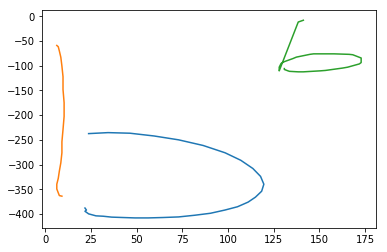

In [0]:
plot_stroke(moved)

In [0]:
lmoved = moved.tolist()

In [0]:
lmoved

In [0]:
moved_x.shape

(84,)

In [0]:
moved[stroke_input[:, :, 2]==1].shape

(84, 3)

In [0]:
out_tensor[2][out_tensor[2, :, 2]==1]

In [0]:
out_tensor[2][out_tensor[2, :, 2]==1].shape

(32, 3)

In [0]:
rowXY[:, 0]

array([ 94., 147., 207., 273., 340., 407., 467., 510., 543., 564., 573.,
       567., 550., 530., 501., 467., 427., 384., 340., 297., 257., 221.,
       188., 157., 134., 114., 101.,  94.,  88.,  84.,  88.,  84.],
      dtype=float32)

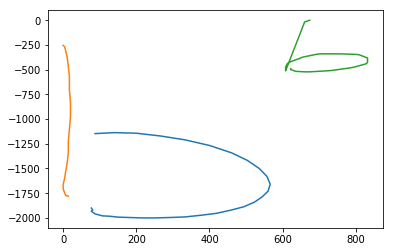

In [0]:
plot_stroke(out_tensor)

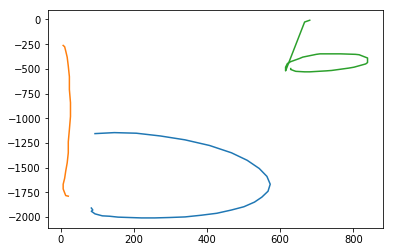

In [0]:
plot_stroke(stroke_input)

### Investigation

Future input affect current result, it is bug.

In [0]:
dec = tf.expand_dims(tf.constant(np.array([112, 77, 75, 90, 113]), dtype=tf.int32), axis=0)
embed = myembedding(dec, VOCAB_SIZE, EMBEDDING_SIZE, 5, "mytest")


In [0]:
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  res = sess.run([embed])

In [0]:
res[0].shape

(1, 5, 32)

In [0]:
train_input_embed = res[0]

In [0]:
dec_pred = tf.expand_dims(tf.constant(np.array([112, 0, 0, 0, 0]), dtype=tf.int32), axis=0)
embed_pred = myembedding(dec_pred, VOCAB_SIZE, EMBEDDING_SIZE, 5, "mytest")


In [0]:
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  res_pred = sess.run([embed_pred])

In [0]:
res[0][0, 0, :] == res_pred[0][0, 0, :]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [0]:
dec2 = tf.expand_dims(tf.constant(np.array([112, 77, 75, 90, 113]), dtype=tf.int32), axis=0)
embed2 = myembedding(dec2, VOCAB_SIZE, EMBEDDING_SIZE, 5, "mytest")


In [0]:
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  res2 = sess.run([embed2])

In [0]:
res[0][0, 0, :] == res2[0][0, 0, :]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [0]:
dec = tf.expand_dims(tf.constant(np.array([112, 77, 75, 90, 113]), dtype=tf.int32), axis=0)
embed = myembedding(dec, VOCAB_SIZE, EMBEDDING_SIZE, 5, "mytest")
dec2 = tf.expand_dims(tf.constant(np.array([112, 77, 75, 90, 113]), dtype=tf.int32), axis=0)
embed2 = myembedding(dec2, VOCAB_SIZE, EMBEDDING_SIZE, 5, "mytest")
dec_pred = tf.expand_dims(tf.constant(np.array([112, 0, 0, 0, 0]), dtype=tf.int32), axis=0)
embed_pred = myembedding(dec_pred, VOCAB_SIZE, EMBEDDING_SIZE, 5, "mytest")


In [0]:
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  res, res_embed2, res_pred = sess.run([embed, embed2, embed_pred])

In [0]:
res.shape

(1, 5, 32)

In [0]:
res[0].shape

(5, 32)

In [0]:
(res[0][0, :] == res_pred[0][0, :]).all()

True

In [0]:
(res[0] == res_embed2[0]).all()

True

In [0]:
decoder_input_t = tf.placeholder(tf.int32, shape=[1, MAX_TOKEN_LEN], name='input_decoder')

In [0]:
def decoderCNN(decoder_input_t, is_training=False):
  
  # dec_input_embedded = Embedding(VOCAB_SIZE, EMBEDDING_SIZE, input_length=decoder_input_t.shape[1])(decoder_input_t)
  dec_input_embedded = myembedding(decoder_input_t, VOCAB_SIZE, EMBEDDING_SIZE, MAX_TOKEN_LEN, "dec_embed")
  # (batch, 5, 256)
  
  dec_pos_input = tf.range(
            0,
            tf.shape(decoder_input_t)[1],
            delta=1,
            dtype=tf.int32,
            name='range')
  
  # [5] -> [1, 5, 1]
  # dec_pos_input = tf.expand_dims(tf.expand_dims(dec_pos_input, axis=1), axis=0)
  # [5] -> [1, 5]
  dec_pos_input = tf.expand_dims(dec_pos_input, axis=0)
  # dec_pos_embed = Embedding(MAX_TOKEN_LEN, EMBEDDING_SIZE, input_length=MAX_TOKEN_LEN)(dec_pos_input)
  dec_pos_embed = myembedding(dec_pos_input, MAX_TOKEN_LEN, EMBEDDING_SIZE, MAX_TOKEN_LEN, "dec_pos_embed")
  
  
  dec_embedded = dec_input_embedded + tf.cast(x=dec_pos_embed, dtype=dec_input_embedded.dtype)
  # [batch, 5, 32]
  
  # dec_embedded OK
  # return dec_embedded
  
  x = Conv1D(FILTER_SIZE, KERNEL_SIZE, activation='relu', padding='causal', kernel_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), bias_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), activity_regularizer=regularizers.l2(L2_REGULARIZATION_RATE))(dec_embedded)
  # return x
  # OK
  # x = tf.contrib.layers.layer_norm(x)
  # return x
  # NG!
  ht_dec = SpatialDropout1D(DROPOUT_RATE)(x, training=is_training)
  return ht_dec
  #NG 


In [0]:
ht_dec_place = decoderCNN(decoder_input_t)

In [0]:
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  res_ht = sess.run([ht_dec_place], feed_dict={decoder_input_t: np.array([[112, 77, 75, 90, 113]])})
  res_ht_pred = sess.run([ht_dec_place], feed_dict={decoder_input_t: np.array([[112, 0, 0, 0, 0]])})
  res_ht2 = sess.run([ht_dec_place], feed_dict={decoder_input_t: np.array([[112, 77, 75, 90, 113]])})

In [0]:
(res_ht[0] == res_ht2[0]).all()

True

In [0]:
res_ht[0].shape

(1, 5, 5)

In [0]:
(res_ht[0][0, 0, :] == res_ht_pred[0][0, 0, :]).all()

True

In [0]:
ht_dec = decoderCNN(dec)
ht_dec2 = decoderCNN(dec2)
ht_dec_pred = decoderCNN(dec_pred)

In [0]:
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  res_ht, res_ht2, res_ht_pred = sess.run([ht_dec, ht_dec2, ht_dec_pred])

In [0]:
res_ht.shape, res_ht2.shape, res_ht_pred.shape

((1, 5, 5), (1, 5, 5), (1, 5, 5))

In [0]:
(res_ht == res_ht2).any()

False

In [0]:
with tf.Session() as sess:
  print(sess.run([tf.one_hot(dec, VOCAB_SIZE)]))

[array([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.,

In [0]:
with tf.variable_scope("mytest", reuse=tf.AUTO_REUSE):
  randinitializer = lambda: tf.random_uniform([VOCAB_SIZE, EMBEDDING_SIZE], -0.05, 0.05)

  embedmat = tf.get_variable("mytest", initializer = randinitializer)

In [0]:
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())

In [0]:
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  res_embedmat = sess.run([embedmat])[0]

FailedPreconditionError: ignored

In [0]:
flatten_onehot = tf.reshape(onehot, [-1, num_classes])

In [0]:
def myembedding(input, num_classes, embedding_size, seq_num, name):
  with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
    randinitializer = lambda: tf.random_uniform([num_classes, embedding_size], -0.05, 0.05)

    embedmat = tf.get_variable(name, initializer = randinitializer)
    # embedding_lookup with generated tensor (eg. tf.range) cause TFLite convert fail.
    # return tf.nn.embedding_lookup(embedmat, input)
    onehot = tf.one_hot(input, num_classes)
    # batch_num, seqnum = onehot.shape[0], onehot.shape[1]    
    # flatten_onehot = tf.reshape(onehot, [batch_num*seq_num, num_classes])
    flatten_onehot = tf.reshape(onehot, [-1, num_classes])
    return tf.reshape(tf.matmul(flatten_onehot, embedmat), [-1, seq_num, embedding_size])


In [0]:
EMBEDDING_SIZE

32

In [0]:
def myembedding(input, num_classes, embedding_size, seq_num, name):
